In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, accuracy_score, f1_score, precision_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_columns', None)

In [42]:
df = pd.read_csv(r"C:\Users\Admin\Documents\DATA.COM\Nouveau dossier\train_ch.csv")
df3=pd.read_excel(r"C:\Users\Admin\Documents\DATA.COM\Nouveau dossier\02 Customer Churn-Dataset.xlsx")

df.head()   

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,6918-UMQCG,Female,0,No,No,5,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,No,Electronic check,80.20,384.25,4,0,No
1,4140-MUHUG,Female,1,No,No,3,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,86.85,220.95,1,0,Yes
2,5570-PTWEH,Female,0,Yes,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.15,216.75,5,0,Yes
3,2054-PJOCK,Female,0,No,No,60,Yes,Yes,DSL,No,No,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),80.55,4847.05,0,0,No
4,4315-MURBD,Female,0,No,No,12,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),98.90,1120.95,1,2,Yes


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4930 non-null   object 
 1   gender            4930 non-null   object 
 2   SeniorCitizen     4930 non-null   int64  
 3   Partner           4930 non-null   object 
 4   Dependents        4930 non-null   object 
 5   tenure            4930 non-null   int64  
 6   PhoneService      4930 non-null   object 
 7   MultipleLines     4930 non-null   object 
 8   InternetService   4930 non-null   object 
 9   OnlineSecurity    4930 non-null   object 
 10  OnlineBackup      4930 non-null   object 
 11  DeviceProtection  4930 non-null   object 
 12  TechSupport       4930 non-null   object 
 13  StreamingTV       4930 non-null   object 
 14  StreamingMovies   4930 non-null   object 
 15  Contract          4930 non-null   object 
 16  PaperlessBilling  4930 non-null   object 


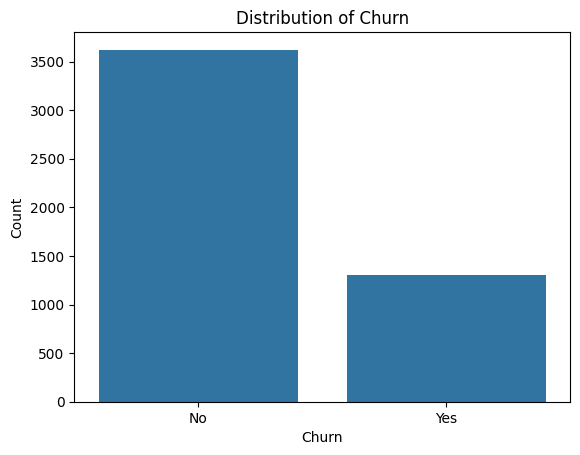

In [44]:
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [45]:
def remove_duplicates(df, subset=None, keep='first', inplace=False):
    
    if keep not in ['first', 'last', 'none']:
        raise ValueError("keep must be one of 'first', 'last', or 'none'.")
    
   
    total_rows = len(df)
    duplicate_rows = df.duplicated(subset=subset, keep=False).sum()
    percentage_duplicates = (duplicate_rows / total_rows) * 100
    
    print(f"Total Rows: {total_rows}")
    print(f"Duplicate Rows: {duplicate_rows} ({percentage_duplicates:.2f}%)")
    
    if duplicate_rows == 0:
        print("No duplicates found. No rows removed.")
        return df if not inplace else None
    
    if keep == 'none':
        
        duplicated_mask = df.duplicated(subset=subset, keep=False)
        result = df[~duplicated_mask]
    else:
        
        result = df.drop_duplicates(subset=subset, keep=keep)
    
    
    remaining_rows = len(result)
    rows_removed = total_rows - remaining_rows
    
    print(f"Rows Removed: {rows_removed}")
    print(f"Remaining Rows: {remaining_rows}")
    
    if rows_removed > 0:
        print("Duplicates successfully removed.")
    else:
        print("No duplicates were removed.")
    
    if inplace:
        df.drop_duplicates(subset=subset, keep=keep, inplace=True)
    else:
        return result

In [46]:
df=remove_duplicates(df)
df=remove_duplicates(df3)

Total Rows: 4930
Duplicate Rows: 0 (0.00%)
No duplicates found. No rows removed.
Total Rows: 7043
Duplicate Rows: 0 (0.00%)
No duplicates found. No rows removed.


In [47]:
def handle_outliers(df, numerical_columns=None, method='IQR', verbose=True):
    
  
    if numerical_columns is None:
        numerical_columns = df.select_dtypes(include=['number']).columns
    
    
    for col in numerical_columns:
        if col in df.columns:
            if method == 'IQR':
              
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                
                outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))
                num_outliers = outliers.sum()
                
               
                df.loc[df[col] < lower_bound, col] = lower_bound
                df.loc[df[col] > upper_bound, col] = upper_bound
                
                if verbose:
                    print(f"[INFO] Outliers handled in '{col}' using IQR:")
                    print(f"         - Number of Outliers: {num_outliers}")
                    print(f"         - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
            
            elif method == 'Z-Score':
                
                mean = df[col].mean()
                std_dev = df[col].std()
                threshold = 3  
                
                
                outliers = ((df[col] < (mean - threshold * std_dev)) | (df[col] > (mean + threshold * std_dev)))
                num_outliers = outliers.sum()
                
                
                lower_bound = mean - threshold * std_dev
                upper_bound = mean + threshold * std_dev
                df.loc[df[col] < lower_bound, col] = lower_bound
                df.loc[df[col] > upper_bound, col] = upper_bound
                
                if verbose:
                    print(f"[INFO] Outliers handled in '{col}' using Z-Score:")
                    print(f"         - Number of Outliers: {num_outliers}")
                    print(f"         - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    
    return df

In [48]:
df=handle_outliers(df)
df=handle_outliers(df3)

[INFO] Outliers handled in 'SeniorCitizen' using IQR:
         - Number of Outliers: 1142
         - Lower Bound: 0.0, Upper Bound: 0.0
[INFO] Outliers handled in 'tenure' using IQR:
         - Number of Outliers: 0
         - Lower Bound: -60.0, Upper Bound: 124.0
[INFO] Outliers handled in 'MonthlyCharges' using IQR:
         - Number of Outliers: 0
         - Lower Bound: -46.02499999999999, Upper Bound: 171.375
[INFO] Outliers handled in 'numAdminTickets' using IQR:
         - Number of Outliers: 1201
         - Lower Bound: 0.0, Upper Bound: 0.0
[INFO] Outliers handled in 'numTechTickets' using IQR:
         - Number of Outliers: 970
         - Lower Bound: 0.0, Upper Bound: 0.0
[INFO] Outliers handled in 'SeniorCitizen' using IQR:
         - Number of Outliers: 0
         - Lower Bound: 0.0, Upper Bound: 0.0
[INFO] Outliers handled in 'tenure' using IQR:
         - Number of Outliers: 0
         - Lower Bound: -60.0, Upper Bound: 124.0
[INFO] Outliers handled in 'MonthlyCharges' 

In [49]:
def get_object_columns(df):
 
    return df.select_dtypes(include='object').columns.tolist()


object_columns = get_object_columns(df)
print(object_columns)

['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


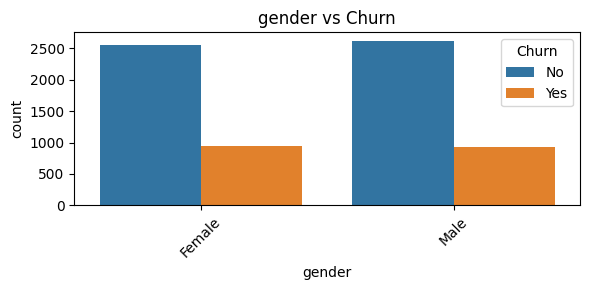

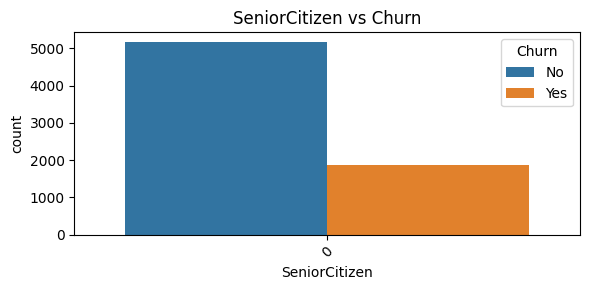

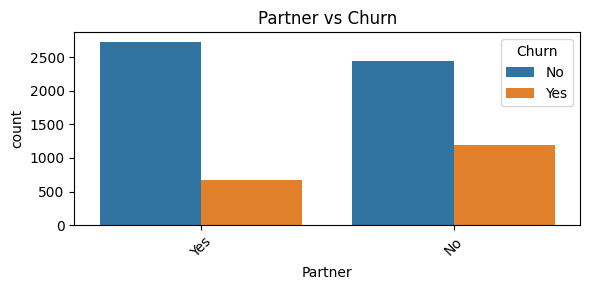

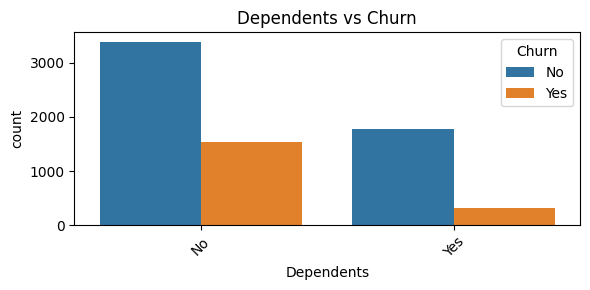

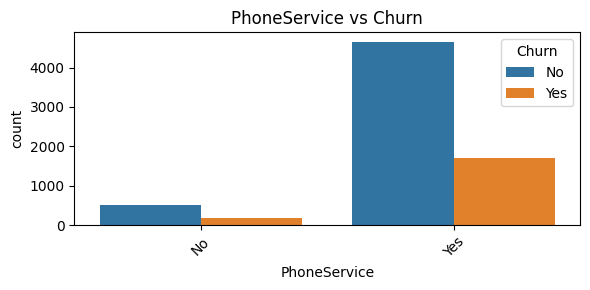

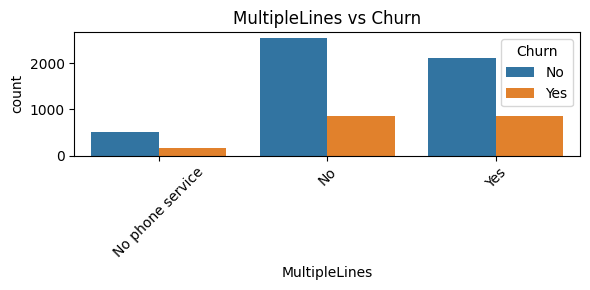

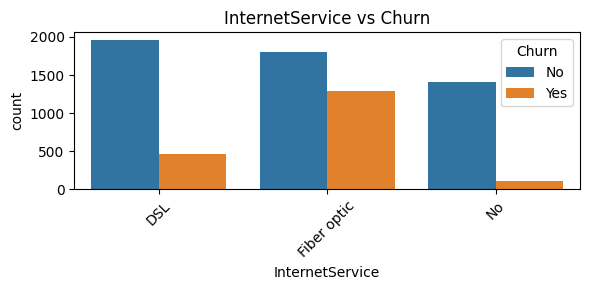

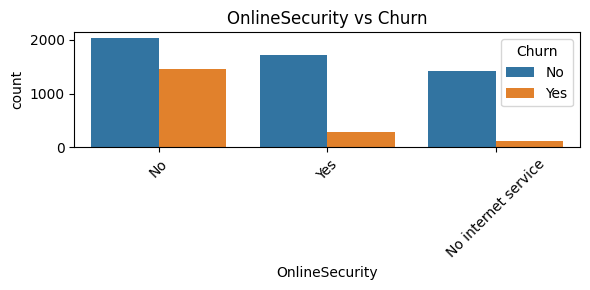

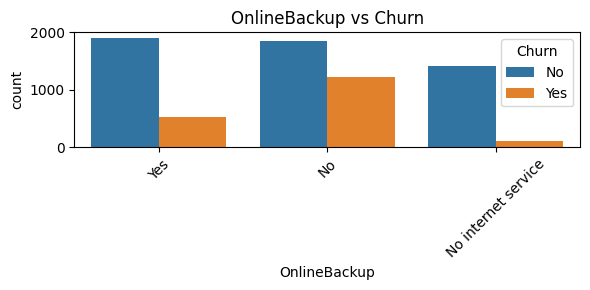

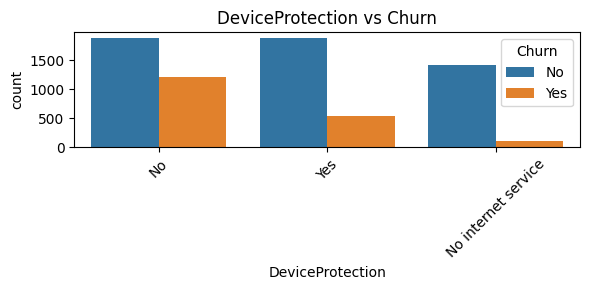

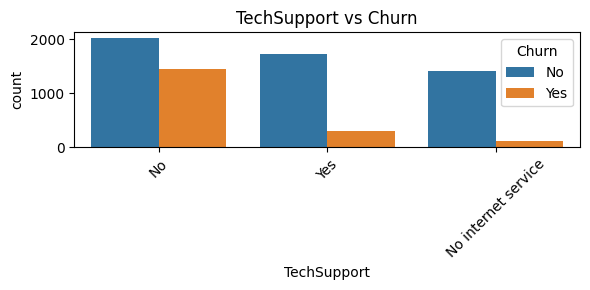

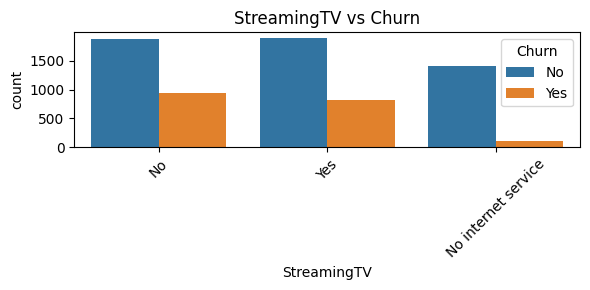

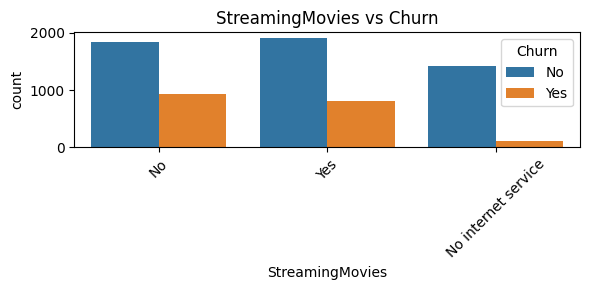

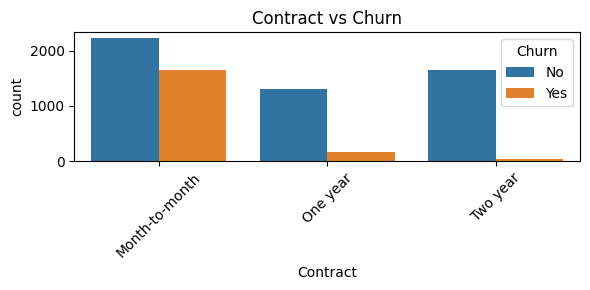

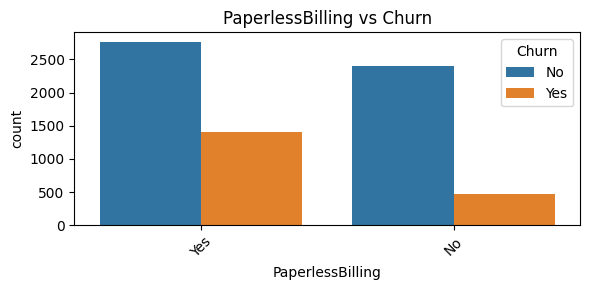

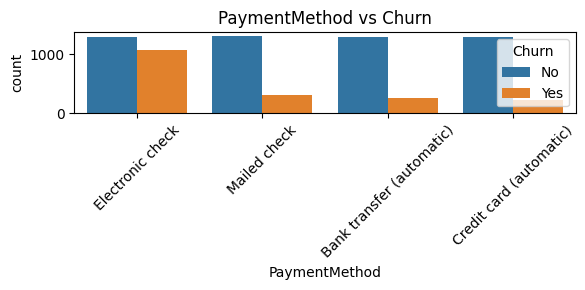

In [50]:
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
               'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in categorical:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


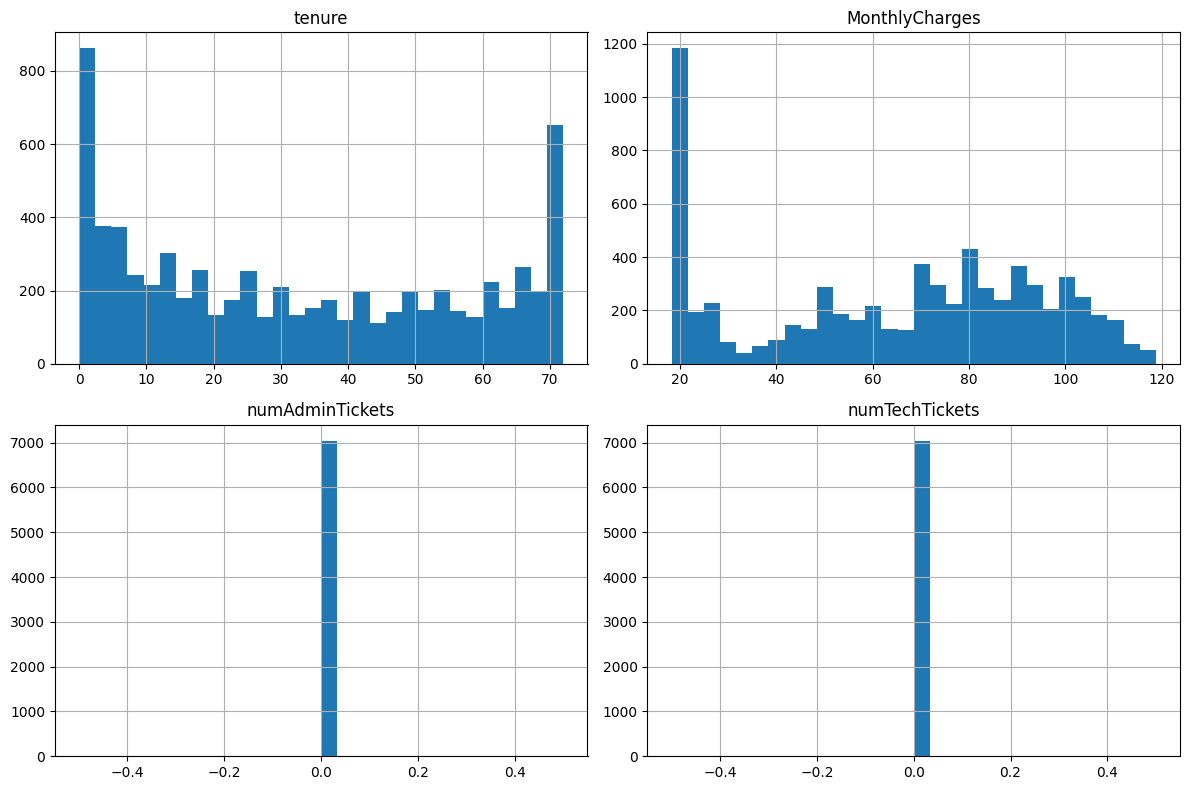

In [51]:
numeric1 = ['tenure', 'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets']

df[numeric1].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()


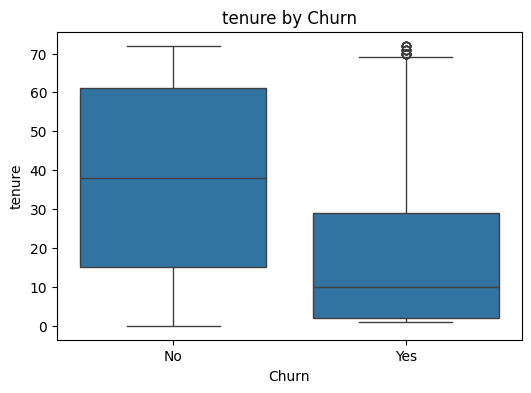

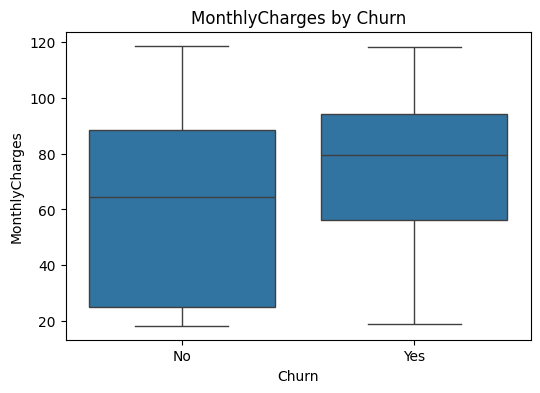

In [52]:


numeric = ['tenure', 'MonthlyCharges']
for col in numeric:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} by Churn")
    plt.show()


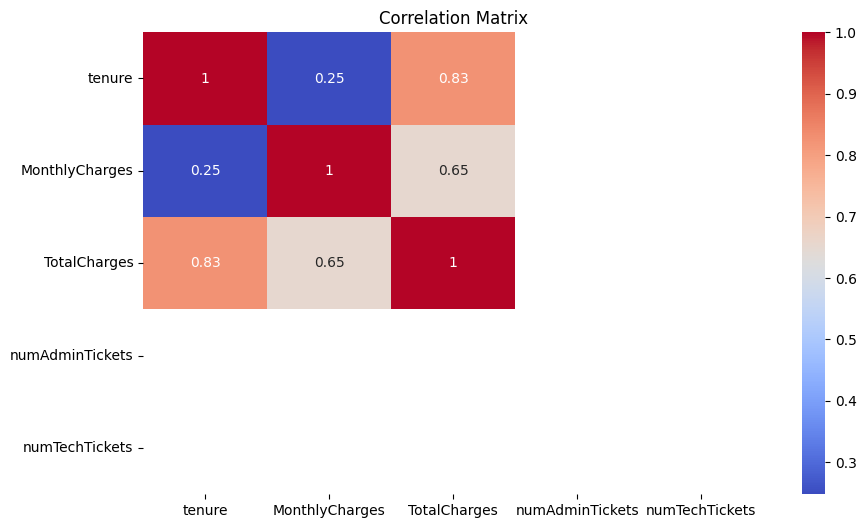

In [53]:
df[numeric1] = df[numeric1].apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
plt.figure(figsize=(10, 6))
corr = df[numeric1].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


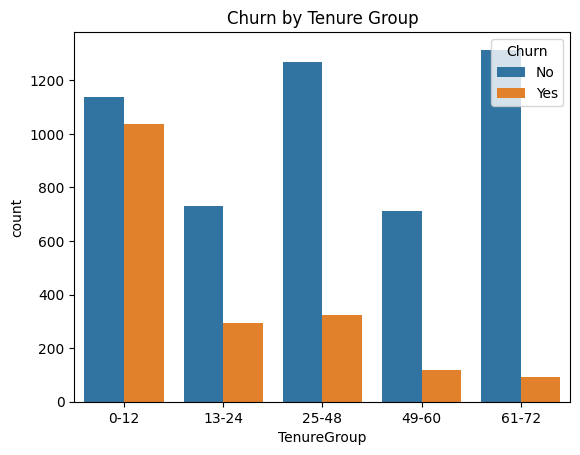

In [54]:
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72], 
                           labels=['0-12', '13-24', '25-48', '49-60', '61-72'])

sns.countplot(x='TenureGroup', hue='Churn', data=df)
plt.title("Churn by Tenure Group")
plt.show()



df3['TenureGroup'] = pd.cut(df3['tenure'], bins=[0, 12, 24, 48, 60, 72], 
                           labels=['0-12', '13-24', '25-48', '49-60', '61-72'])





In [55]:


imputer_cat = SimpleImputer(strategy='most_frequent')
categorical_cols = df.select_dtypes(include=[object]).columns

categorical_cols = [col for col in categorical_cols if col != 'Churn']

# Apply the imputer
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])
df3[categorical_cols] = imputer_cat.transform(df3[categorical_cols])
# One-Hot encoding for multi-category columns like 'InternetService', 'Contract', and 'PaymentMethod'
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
df3 = pd.get_dummies(df3, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
df_binary = df.copy()


df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn,TenureGroup,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,No,Yes,No,No,No,No,Yes,29.85,29.85,0,0,No,0-12,False,False,False,False,False,True,False
1,5575-GNVDE,Male,0,No,No,34,Yes,No,Yes,No,Yes,No,No,No,No,56.95,1889.50,0,0,No,25-48,False,False,True,False,False,False,True
2,3668-QPYBK,Male,0,No,No,2,Yes,No,Yes,Yes,No,No,No,No,Yes,53.85,108.15,0,0,Yes,0-12,False,False,False,False,False,False,True
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,Yes,No,Yes,Yes,No,No,No,42.30,1840.75,0,0,No,25-48,False,False,True,False,False,False,False
4,9237-HQITU,Female,0,No,No,2,Yes,No,No,No,No,No,No,No,Yes,70.70,151.65,0,0,Yes,0-12,True,False,False,False,False,True,False


In [56]:

df_binary = df.copy()
df_binary.replace({
    'Yes': 1,
    'No': 0,
    True: 1,
    False: 0
}, inplace=True)
df=df_binary
df.head()

df_binary3 = df3.copy()
df_binary3.replace({
    'Yes': 1,
    'No': 0,
    True: 1,
    False: 0
}, inplace=True)
df3=df_binary3
df3.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17284\1701872307.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_binary.replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_17284\1701872307.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_binary3.replace({


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn,TenureGroup,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0-12,0,0,0,0,0,1,0
1,5575-GNVDE,Male,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,25-48,0,0,1,0,0,0,1
2,3668-QPYBK,Male,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,0,0,1,0-12,0,0,0,0,0,0,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,25-48,0,0,1,0,0,0,0
4,9237-HQITU,Female,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,0,0,1,0-12,1,0,0,0,0,1,0


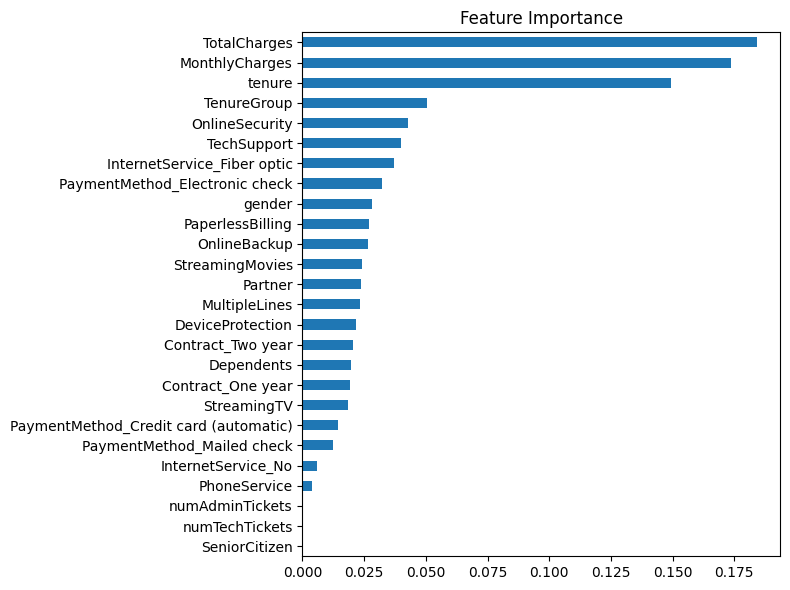

TotalCharges                             0.184340
MonthlyCharges                           0.173661
tenure                                   0.149456
TenureGroup                              0.050642
OnlineSecurity                           0.042793
TechSupport                              0.040049
InternetService_Fiber optic              0.037291
PaymentMethod_Electronic check           0.032369
gender                                   0.028314
PaperlessBilling                         0.026941
OnlineBackup                             0.026745
StreamingMovies                          0.024191
Partner                                  0.023548
MultipleLines                            0.023226
DeviceProtection                         0.021758
Contract_Two year                        0.020499
Dependents                               0.019782
Contract_One year                        0.019245
StreamingTV                              0.018529
PaymentMethod_Credit card (automatic)    0.014477


In [57]:
categorical = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup' ]
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

df_encoded = df.copy()

for col in (set(categorical) & set(df_encoded.columns)).union(['Churn']):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

features = df_encoded.drop(['Churn', 'customerID'], axis=1)
target = df_encoded['Churn']

model = RandomForestClassifier(random_state=42)
model.fit(features, target)

importances = pd.Series(model.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()
print(importances.sort_values(ascending=False))

In [58]:


categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_encoded = df.copy()

for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))


df_encoded['Charges_per_Month'] = df_encoded['TotalCharges'] / (df_encoded['tenure'] + 1e-6)


X = df_encoded.drop(['Churn', 'customerID'], axis=1)
y = df_encoded['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
from sklearn.metrics import accuracy_score  

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


from sklearn.metrics import f1_score, precision_score, recall_score 

best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)  
val_f1 = f1_score(y_val, y_val_pred) 
val_precision = precision_score(y_val, y_val_pred)  
val_recall = recall_score(y_val, y_val_pred)  
val_roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation ROC-AUC: {val_roc_auc:.4f}")


Validation Accuracy: 0.8006
Validation F1 Score: 0.5874
Validation Precision: 0.6601
Validation Recall: 0.5291
Validation ROC-AUC: 0.7146


In [59]:


df3_encoded = df3.copy()

for col in categorical_cols:
    df3_encoded[col] = LabelEncoder().fit_transform(df3_encoded[col].astype(str))


df3_encoded['Charges_per_Month'] = df3_encoded['TotalCharges'] / (df3_encoded['tenure'] + 1e-6)

X_real = df3_encoded.drop(['Churn', 'customerID'], axis=1)
y_real = df3_encoded['Churn']

y_real_pred = best_model.predict(X_real)

real_accuracy = accuracy_score(y_real, y_real_pred)
real_f1 = f1_score(y_real, y_real_pred)
real_precision = precision_score(y_real, y_real_pred)
real_recall = recall_score(y_real, y_real_pred)
real_roc_auc = roc_auc_score(y_real, y_real_pred)

print("\n--- Real Data (df3) Performance ---")
print(f"Real Data Accuracy: {real_accuracy:.4f}")
print(f"Real Data F1 Score: {real_f1:.4f}")
print(f"Real Data Precision: {real_precision:.4f}")
print(f"Real Data Recall: {real_recall:.4f}")
print(f"Real Data ROC-AUC: {real_roc_auc:.4f}")

print("\nClassification Report:\n", classification_report(y_real, y_real_pred))
print("Confusion Matrix:\n", confusion_matrix(y_real, y_real_pred))



--- Real Data (df3) Performance ---
Real Data Accuracy: 0.9167
Real Data F1 Score: 0.8359
Real Data Precision: 0.8753
Real Data Recall: 0.7999
Real Data ROC-AUC: 0.8794

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      5174
           1       0.88      0.80      0.84      1869

    accuracy                           0.92      7043
   macro avg       0.90      0.88      0.89      7043
weighted avg       0.92      0.92      0.92      7043

Confusion Matrix:
 [[4961  213]
 [ 374 1495]]
